
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [2]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn

seaborn.set_context('talk')

url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [25]:
# complete here if you want to include more columns
salary_col = 'salary_monthly_NETO'
lang_col = 'tools_programming_languages'
framework_col = 'tools_frameworks'
relevant_columns = [lang_col, salary_col, framework_col, "work_role"]

In [26]:
# Normalize columns types
df['salary_monthly_NETO'] = df['salary_monthly_NETO'].astype(float)

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

def remove_outlier(df_in, col_name, iqr_factor = 1.5):
    """
    IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
    accept a dataframe, remove outliers, return cleaned data in a new dataframe
    see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 # interquartile range
    fence_low  = q1 - iqr_factor*iqr
    fence_high = q3 + iqr_factor*iqr
    df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return df_inliers, df_outliers

In [28]:
display(len(df))

df_inliers, df_outliers = remove_outlier(df, 'salary_monthly_NETO', 3.5)

# inliers percent over total
display(len(df_inliers)/len(df))

# display df without outliers
df_inliers['salary_monthly_NETO'].describe()

5504

0.9989098837209303

count      5498.000000
mean      84673.532339
std       44279.136065
min        8500.000000
25%       53305.000000
50%       78000.000000
75%      104559.750000
max      285000.000000
Name: salary_monthly_NETO, dtype: float64

In [29]:
# Salario Mínimo en Argentina
# referencia: https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina

min_salary_2021 = float(16875) # de Octubre 2019 a Octubre del 2020 (la encuesta es de Julio/Agosto 2020)

df_outliers_lower_limit = df_inliers.query('salary_monthly_NETO < @min_salary_2021/2.0')
df_inliers_lower_limit = df_inliers.query('salary_monthly_NETO >= @min_salary_2021/2.0')

df = df_inliers_lower_limit
df['salary_monthly_NETO'].describe()

count      5498.000000
mean      84673.532339
std       44279.136065
min        8500.000000
25%       53305.000000
50%       78000.000000
75%      104559.750000
max      285000.000000
Name: salary_monthly_NETO, dtype: float64

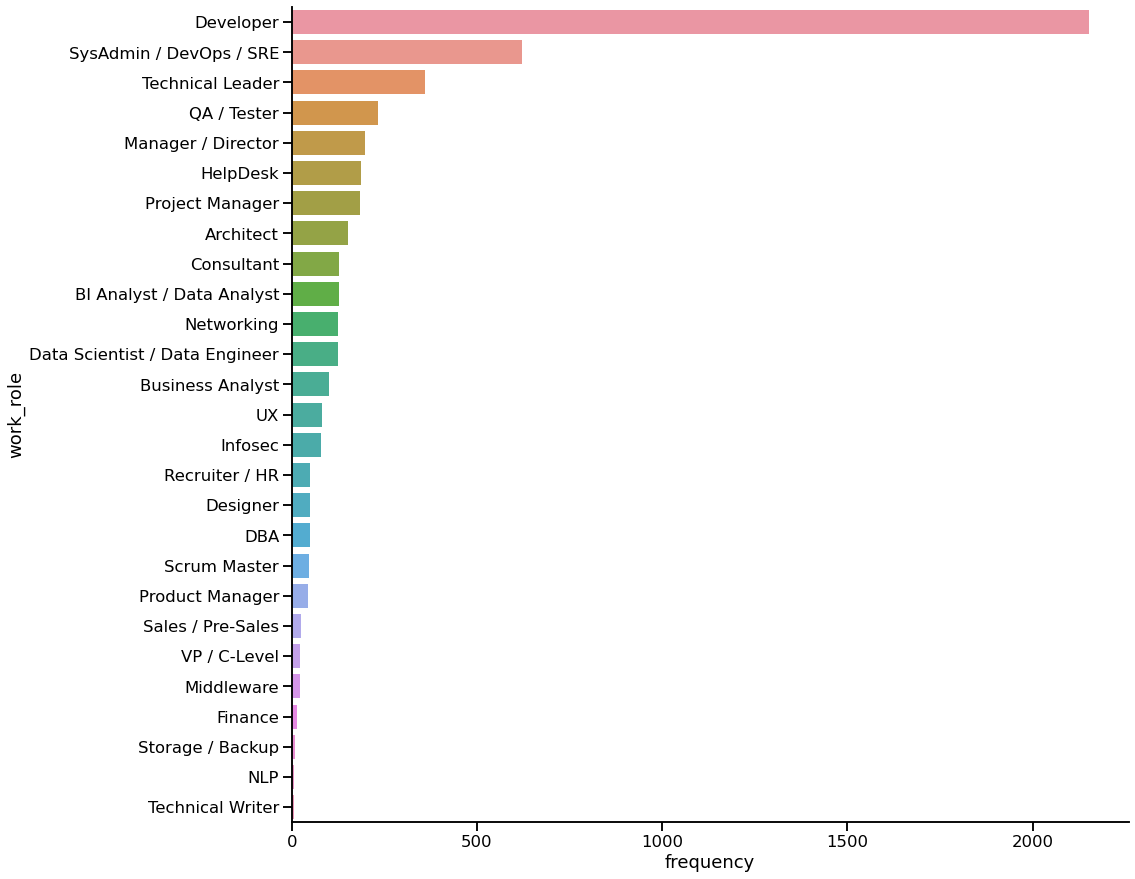

In [30]:
df_roles_count=df['work_role'].value_counts().reset_index().rename(columns={'index':'work_role', 'work_role':'frequency'})
fig = plt.figure(figsize=(15,15))
seaborn.barplot(data = df_roles_count[df_roles_count['frequency'] > 5], x='frequency', y='work_role')
seaborn.despine()

In [76]:
interesting_roles = list(df_roles_count[df_roles_count.frequency > 10]["work_role"])
interesting_roles

['Developer',
 'SysAdmin / DevOps / SRE',
 'Technical Leader',
 'QA / Tester',
 'Manager / Director',
 'HelpDesk',
 'Project Manager',
 'Architect',
 'Consultant',
 'BI Analyst / Data Analyst',
 'Networking',
 'Data Scientist / Data Engineer',
 'Business Analyst',
 'UX',
 'Infosec',
 'Recruiter / HR',
 'Designer',
 'DBA',
 'Scrum Master',
 'Product Manager',
 'Sales / Pre-Sales',
 'VP / C-Level',
 'Middleware',
 'Finance']

In [32]:
df['salary_monthly_NETO']

0        43000.0
1        63000.0
2       127000.0
3       102000.0
4       106000.0
          ...   
6088     56450.0
6089    130000.0
6090     97000.0
6091     71000.0
6094     65000.0
Name: salary_monthly_NETO, Length: 5498, dtype: float64

In [33]:
# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})

## Ejercicio 1 - Analisis Descriptivo

In [77]:
# Filter out languages that we want to exclude
# Complete here with your selected list.
interesting_languages = ["javascript", "sql", "html", "python", "java", "php"\
                         , ".net", "typescript", "c#", "go", "c++", "c", "vba", "kotlin", "swift"]
df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
df_lang = df_lang[df_lang.work_role.isin(interesting_roles)]

In [78]:
remove_outlier(df_lang[df_lang["programming_language"] == "python"], "salary_monthly_NETO")

In [85]:
df[df["salary_monthly_NETO"] < 16000]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,...,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city,cured_programming_languages
106,Hombre,30,Argentina,Chaco,7.0,3.0,3.0,0,Universitario,Completado,...,¿Qué les importa?,NaN,NaN,11-50,Servicios / Consultoría de Software / Digital,5,4,Horarios flexibles,NaN,"[bash/shell, css, html, javascript, php, pytho..."
450,Hombre,23,Argentina,Ciudad Autónoma de Buenos Aires,1.5,1.5,1.5,0,Universitario,En curso,...,Homosexual,NaN,NaN,51-100,Servicios / Consultoría de Software / Digital,8,9,"Capacitaciones y/o cursos, Clases de idiomas",NaN,"[.net, php, sql]"
772,Hombre,22,Argentina,GBA,0.0,0.0,0.0,0,Universitario,En curso,...,Heterosexual,NaN,NaN,1-10,Servicios / Consultoría de Software / Digital,6,8,Ninguna de las anteriores,Globant?,"[css, html, javascript, php, sql]"
1316,Mujer,25,Argentina,Ciudad Autónoma de Buenos Aires,5.0,1.5,5.0,0,Universitario,En curso,...,Heterosexual,NaN,NaN,1-10,Otras industrias,1,1,Ninguna de las anteriores,NaN,[html]
1606,Hombre,50,Argentina,Ciudad Autónoma de Buenos Aires,20.0,9.0,5.0,4,Universitario,Completado,...,Heterosexual,NaN,No,11-50,Servicios / Consultoría de Software / Digital,7,7,Abono de celular,NaN,[ninguno]
1814,Hombre,30,Argentina,Tucumán,1.0,1.0,1.0,0,Universitario,Incompleto,...,Heterosexual,NaN,No,1-10,Servicios / Consultoría de Software / Digital,3,2,"Abono de celular, Abono de Internet, Viáticos",Globant,"[c++, java, sql]"
2085,Hombre,28,Argentina,Ciudad Autónoma de Buenos Aires,6.0,2.0,1.0,5,Universitario,Completado,...,Heterosexual,NaN,NaN,51-100,Producto basado en Software,9,7,Horarios flexibles,NaN,"[.net, c#, python, sql]"
2148,Hombre,37,Argentina,Salta,18.0,7.0,7.0,1,Secundario,Completado,...,Heterosexual,NaN,NaN,1-10,Servicios / Consultoría de Software / Digital,5,5,Ninguna de las anteriores,NaN,[ninguno]
2161,Mujer,33,Argentina,Provincia de Buenos Aires,6.0,0.0,0.0,0,Universitario,Completado,...,Heterosexual,NaN,NaN,51-100,Otras industrias,6,10,Capacitaciones y/o cursos,NaN,[ninguno]
2383,Hombre,28,Argentina,Ciudad Autónoma de Buenos Aires,5.0,1.0,1.0,0,Universitario,Completado,...,Homosexual,NaN,NaN,201-500,Servicios / Consultoría de Software / Digital,3,1,"Abono de Internet, Capacitaciones y/o cursos, ...",NaN,"[css, html, java, javascript]"


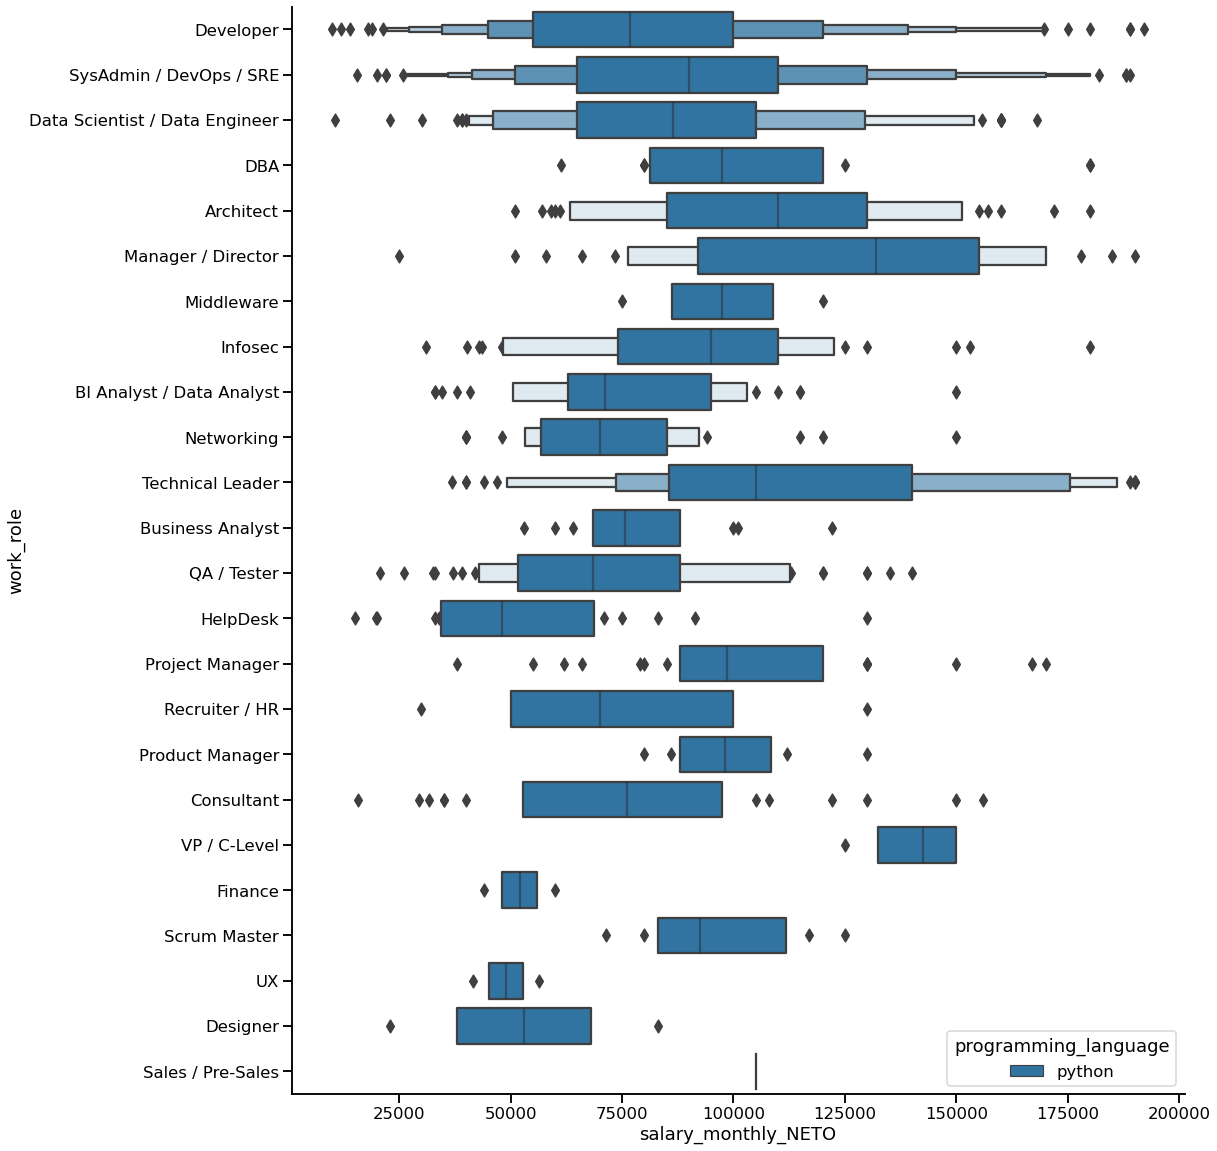

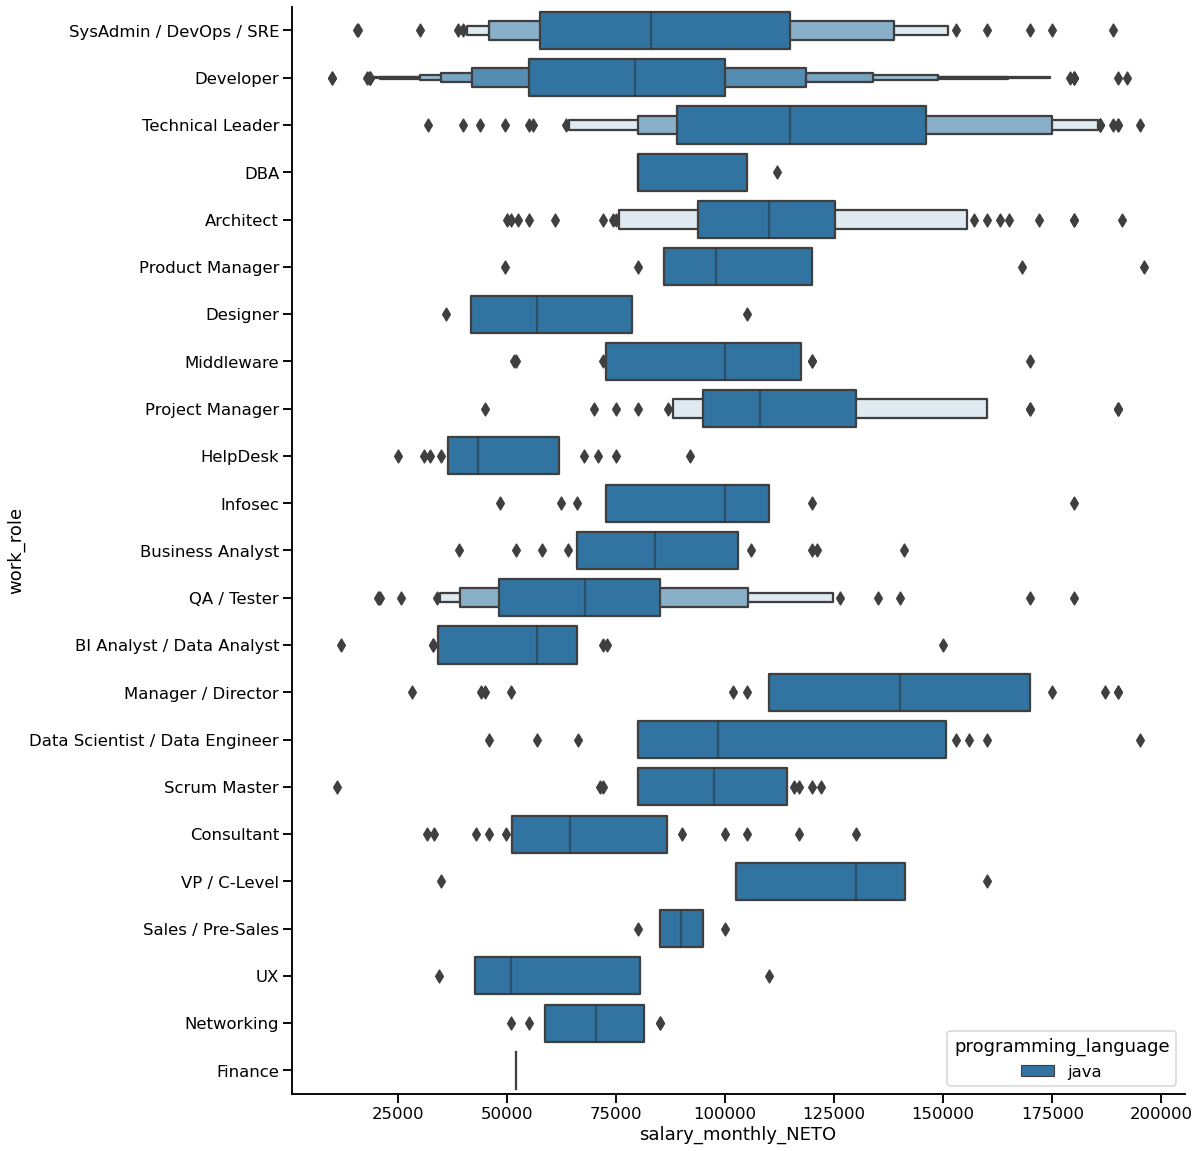

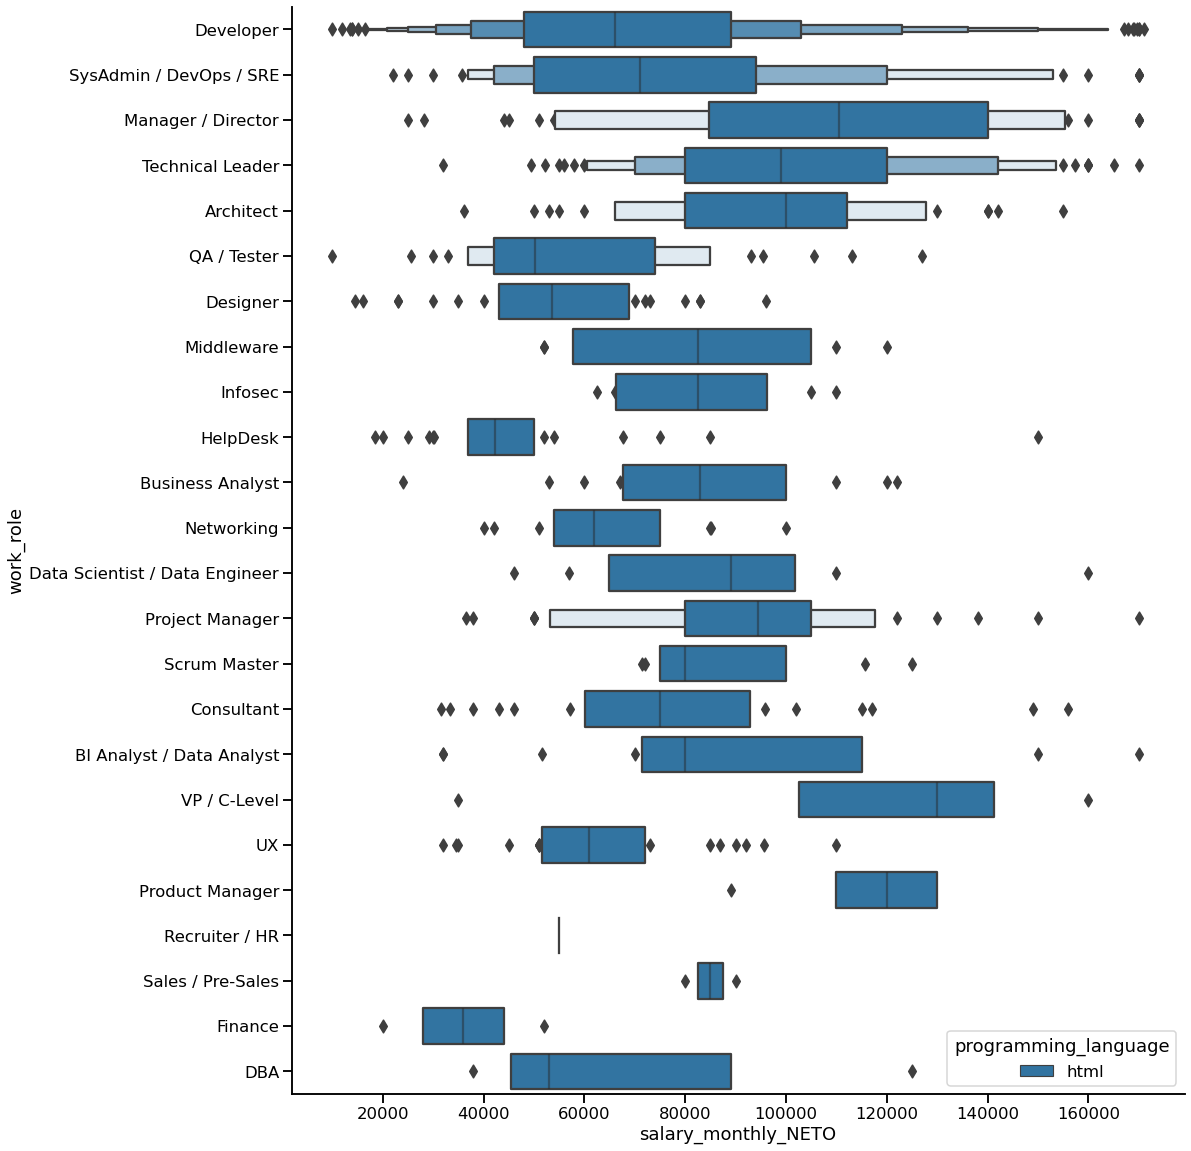

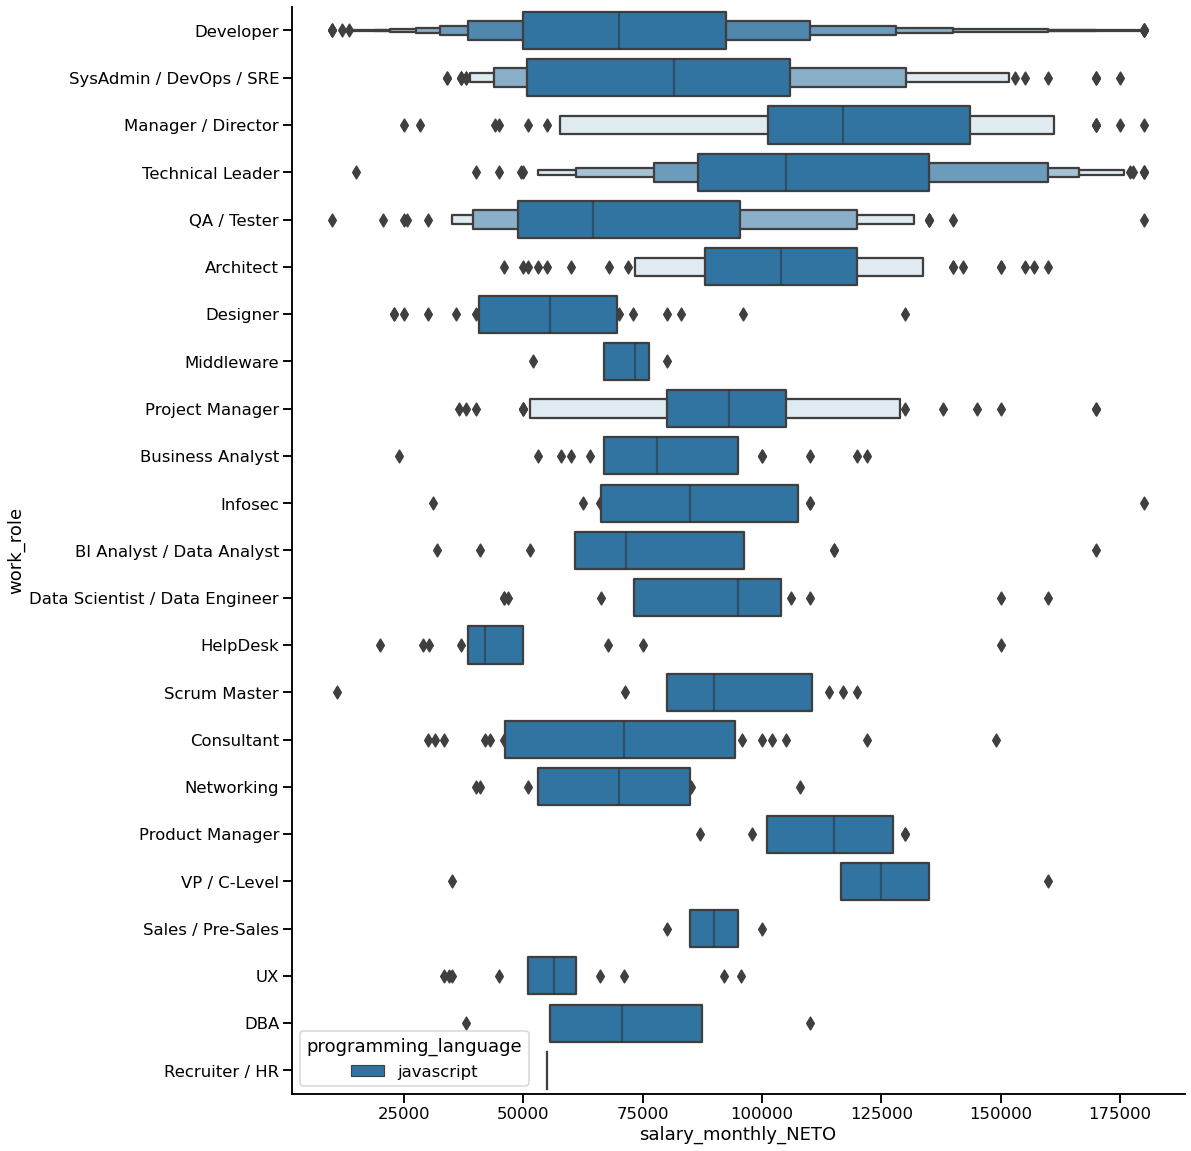

In [79]:
programming_languages = ['python', 'java', 'html', 'javascript']
#fig, axes = plt.subplots(nrows=len(programming_languages), figsize=(16, 10))

for lang in programming_languages:
    fig, axes = plt.subplots(nrows=1, figsize=(16, 20))
    g = seaborn.boxenplot(
        data=remove_outlier(df_lang[df_lang["programming_language"] == lang], "salary_monthly_NETO")[0], 
        x='salary_monthly_NETO',
        y='work_role',
        hue="programming_language"
    )
    plt.ticklabel_format(style='plain', axis='x')
    seaborn.despine()

In [35]:
language_count = filtered_df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})

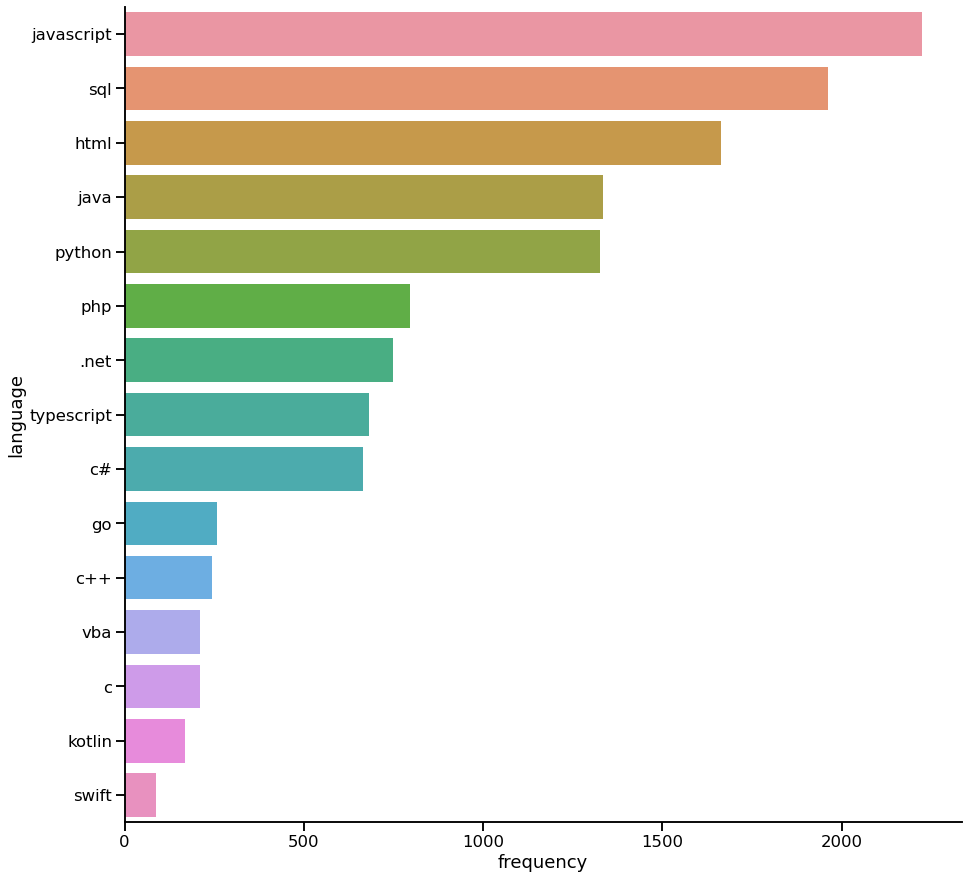

In [36]:
fig = plt.figure(figsize=(15,15))
seaborn.barplot(data = language_count[language_count['frequency'] > 11], x='frequency', y='language')
seaborn.despine()

In [37]:

filtered_df_lang
    
#df.loc[:, ['tools_programming_languages','work_role']]


,programming_language,tools_programming_languages,salary_monthly_NETO,tools_frameworks,cured_programming_languages
1,html,"HTML, Javascript, Python",63000.0,"Django, jQuery","[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,"Django, jQuery","[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,"Django, jQuery","[html, javascript, python]"
3,c,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"jQuery, WordPress","[bash/shell, c, css, html, java, javascript, p..."
3,html,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"jQuery, WordPress","[bash/shell, c, css, html, java, javascript, p..."
...,...,...,...,...,...
6090,html,".NET, C#, COBOL, CSS, HTML, Javascript, PHP, S...",97000.0,"Bootstrap, Drupal, jQuery, Symfony, WordPress","[.net, c#, cobol, css, html, javascript, php, ..."
6090,javascript,".NET, C#, COBOL, CSS, HTML, Javascript, PHP, S...",97000.0,"Bootstrap, Drupal, jQuery, Symfony, WordPress","[.net, c#, cobol, css, html, javascript, php, ..."
6090,php,".NET, C#, COBOL, CSS, HTML, Javascript, PHP, S...",97000.0,"Bootstrap, Drupal, jQuery, Symfony, WordPress","[.net, c#, cobol, css, html, javascript, php, ..."
6090,sql,".NET, C#, COBOL, CSS, HTML, Javascript, PHP, S...",97000.0,"Bootstrap, Drupal, jQuery, Symfony, WordPress","[.net, c#, cobol, css, html, javascript, php, ..."


#### _Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante_

Asociar el lenguaje de programacion al rol que se declara cada uno nos puede ayudar a brindar detalle sobre el tipo de trabajo que se realiza en cada puesto. De esta manera no solamente podemos inferir sobre el salario de los que trabajan en python, sino ademas de los que usan python para distintos propositos, como puede ser, por ejemplo, desarrollo web, o data science. 

In [38]:
language_count[language_count['frequency'] > 11]

,language,frequency
0,javascript,2223
1,sql,1962
2,html,1662
3,java,1334
4,python,1325
5,php,796
6,.net,749
7,typescript,683
8,c#,664
9,go,257


In [39]:
fig = plt.figure(figsize=(15, 20))
g = seaborn.violinplot(
    data=clean_outliers(filtered_df_lang, "salary_monthly_NETO"), 
    x='salary_monthly_NETO',
    y='programming_language', 
)
plt.ticklabel_format(style='plain', axis='x')
seaborn.despine()

NameError: name 'clean_outliers' is not defined

<Figure size 1080x1440 with 0 Axes>

In [92]:
len(df_lang[df_lang["programming_language"].isin(language_count[language_count["frequency"] > 10]["language"])])

12018

In [93]:
len(df_lang)

12018